In [1]:
%load_ext dotenv
%dotenv

import os

%cd {os.getenv("PROJECT_PATH") or "."}

%load_ext autoreload
%autoreload 1

from IPython.display import display

/data/hdd1/users/akouk/ChemFlow/ChemFlow


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
from absl import logging
from tqdm.notebook import tqdm, trange
from timeit import default_timer as timer
import pickle
from collections import defaultdict

logging.set_verbosity(logging.INFO)

In [3]:
from pandarallel import pandarallel

pandarallel.initialize(
    nb_workers=os.cpu_count(),
    progress_bar=True,
    verbose=0
)

In [4]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

In [5]:
from rdkit import Chem

from src.utils.scores import *
from src.vae import load_vae
from src.pinn.pde import load_wavepde
from src.pinn import VAEGenerator

Found local copy...
Found local copy...
Found local copy...


In [28]:
prop = 'plogp'
reverse = prop in MINIMIZE_PROPS

files = [
    (f'data/interim/optimization/{prop}_random_0.1_absolute.csv', 'Random'),
    (f'data/interim/optimization/{prop}_random_1d_0.1_absolute.csv', 'Random 1D'),
    (f'data/interim/optimization/{prop}_limo_0.1_relative.csv', 'Gradient Flow'),
    #(f'data/interim/optimization/{prop}_chemspace_0.1_absolute.csv', 'ChemSpace'),
    (f'data/interim/optimization/{prop}_wave_sup_0.1_relative.csv',
     'Wave eqn. (spv)'),
    (f'data/interim/optimization/{prop}_wave_unsup_0.1_relative.csv',
     'Wave eqn. (unsup)'),
    (f'data/interim/optimization/{prop}_hj_sup_0.1_relative.csv', 'HJ eqn. (spv)'),
    (f'data/interim/optimization/{prop}_hj_unsup_0.1_relative.csv',
     'HJ eqn. (unsup)'),
    (f'data/interim/optimization/{prop}_fp_0.1_relative.csv', 'Langevin Dynamics'),
]

In [29]:
results = []
for file, name in files:
    df_raw = pd.read_csv(file, index_col=0)
    df_init = df_raw.query('t == 0')

    n = df_init.shape[0]
    steps = df_raw.t.max() + 1


    def func(x: pd.Series):
        mol = Chem.MolFromSmiles(x['smiles'])

        if mol is None:
            # x['valid'] = False
            return x
        # x['valid'] = True
        if x['t'] == 0:
            x['sim'] = 1
            x['delta'] = 0
        else:
            try:
                x['sim'] = ssim(x['smiles'], df_init.loc[x['idx'], 'smiles'])
                x['delta'] = x[prop] - df_init.loc[x['idx'], prop]
            except Exception as e:
                # x['valid'] = False
                return x
        return x


    df_imp = df_raw.parallel_apply(func, axis=1).dropna()

    file_path = Path(file)
    #create directory if it doesn't exist
    if not (file_path.parent / 'sims').exists():
        (file_path.parent / 'sims').mkdir(parents=True, exist_ok=True)
    df_imp.to_csv(file_path.parent / 'sims' / file_path.name)
#     for sim in [0, 0.2, 0.4, 0.6]:
#         df_imp = df_imp.query(f'sim >= {sim}')
#         deltas = torch.zeros((n, steps))
#         for _, row in df_imp.iterrows():
#             deltas[row['idx'], row['t']] = row['delta']
# 
#         # improvements = torch.cummax(deltas, dim=1).values
#         # improvements = improvements[:,-1]
#         improvements = torch.max(deltas, dim=1).values
# 
#         succ = (improvements > 0).sum().item() / n
#         improvements = improvements[improvements > 0]
#         r = f'{improvements.mean().item():.2f} ± {improvements.std().item():.2f} ({succ * 100:.1f})'
# 
#         print(f'{name:<20} {sim:.1f}: {r}')
#         
#         results.append({
#             'name': name,
#             'sim': sim,
#             'improvement': r
#         })
# 
# df_results = pd.DataFrame(results)

# show_df(df_results)

[20:11:10] Conflicting single bond directions around double bond at index 11.
[20:11:10]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:10] Conflicting single bond directions around double bond at index 11.
[20:11:10]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:11] Conflicting single bond directions around double bond at index 3.
[20:11:11]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:11] Conflicting single bond directions around double bond at index 3.
[20:11:11]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:11] Conflicting single bond directions around double bond at index 7.
[20:11:11]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:11] Conflicting single bond directions around double bond at index 7.
[20:11:11]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:11:11] Conflicting single bond direction

[20:12:12] Conflicting single bond directions around double bond at index 1.
[20:12:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:12] Conflicting single bond directions around double bond at index 1.
[20:12:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:13] Conflicting single bond directions around double bond at index 1.
[20:12:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:13] Conflicting single bond directions around double bond at index 1.
[20:12:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:14] Conflicting single bond directions around double bond at index 1.
[20:12:14]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:14] Conflicting single bond directions around double bond at index 1.
[20:12:14]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:15] Conflicting single bond directions 

[20:12:43] Conflicting single bond directions around double bond at index 4.
[20:12:43]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:43] Conflicting single bond directions around double bond at index 4.
[20:12:43]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:46] Conflicting single bond directions around double bond at index 4.
[20:12:46]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:46] Conflicting single bond directions around double bond at index 4.
[20:12:46]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:48] Conflicting single bond directions around double bond at index 4.
[20:12:48]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:48] Conflicting single bond directions around double bond at index 4.
[20:12:48]   BondStereo set to STEREONONE and single bond directions set to NONE.
[20:12:49] Conflicting single bond directions 

In [30]:
sim_files = []
for file, name in files:
    file_path = Path(file)
    sim_files.append((file_path.parent / 'sims' / file_path.name, name))

print(sim_files)

[(PosixPath('data/interim/optimization/sims/plogp_random_0.1_absolute.csv'), 'Random'), (PosixPath('data/interim/optimization/sims/plogp_random_1d_0.1_absolute.csv'), 'Random 1D'), (PosixPath('data/interim/optimization/sims/plogp_limo_0.1_relative.csv'), 'Gradient Flow'), (PosixPath('data/interim/optimization/sims/plogp_wave_sup_0.1_relative.csv'), 'Wave eqn. (spv)'), (PosixPath('data/interim/optimization/sims/plogp_wave_unsup_0.1_relative.csv'), 'Wave eqn. (unsup)'), (PosixPath('data/interim/optimization/sims/plogp_hj_sup_0.1_relative.csv'), 'HJ eqn. (spv)'), (PosixPath('data/interim/optimization/sims/plogp_hj_unsup_0.1_relative.csv'), 'HJ eqn. (unsup)'), (PosixPath('data/interim/optimization/sims/plogp_fp_0.1_relative.csv'), 'Langevin Dynamics')]


In [31]:
n = 800
steps = 1000
deltas = torch.zeros((n, steps), device='cuda')
results = []

for file, name in sim_files:
    df = pd.read_csv(file, index_col=0)

    for sim in [0, 0.2, 0.4, 0.6]:
        df = df.query(f'sim >= {sim}')
        deltas.zero_()
        for _, row in df.iterrows():
            deltas[row['idx'], row['t']] = row['delta']
        # improvements = torch.cummax(deltas, dim=1).values
        # improvements = improvements[:,-1]
        improvements = torch.max(deltas, dim=1).values

        succ = (improvements > 0).sum().item() / n
        improvements = improvements[improvements > 0]
        r = f'{improvements.mean().item():.2f} ± {improvements.std().item():.2f} ({succ * 100:.1f})'

        print(f'{name:<20} {sim:.1f}: {r}')

        results.append({
            'name': name,
            'sim': sim,
            'improvement': r
        })

df_results = pd.DataFrame(results)

show_df(df_results)

Random               0.0: 4.53 ± 3.19 (99.5)
Random               0.2: 2.00 ± 2.40 (71.9)
Random               0.4: 1.21 ± 1.11 (49.5)
Random               0.6: 0.99 ± 0.84 (26.0)
Random 1D            0.0: 1.52 ± 1.62 (25.1)
Random 1D            0.2: 1.53 ± 1.62 (24.1)
Random 1D            0.4: 1.32 ± 1.44 (20.6)
Random 1D            0.6: 1.05 ± 0.91 (11.5)
Gradient Flow        0.0: 5.80 ± 5.15 (98.9)
Gradient Flow        0.2: 2.86 ± 3.57 (77.0)
Gradient Flow        0.4: 1.49 ± 1.75 (47.1)
Gradient Flow        0.6: 1.06 ± 1.20 (21.8)
Wave eqn. (spv)      0.0: 2.30 ± 3.58 (42.1)
Wave eqn. (spv)      0.2: 1.95 ± 3.02 (39.0)
Wave eqn. (spv)      0.4: 1.37 ± 1.34 (31.2)
Wave eqn. (spv)      0.6: 1.13 ± 1.01 (15.8)
Wave eqn. (unsup)    0.0: 6.34 ± 5.77 (99.2)
Wave eqn. (unsup)    0.2: 2.82 ± 3.51 (75.9)
Wave eqn. (unsup)    0.4: 1.53 ± 2.19 (51.0)
Wave eqn. (unsup)    0.6: 1.06 ± 1.09 (26.9)
HJ eqn. (spv)        0.0: 5.67 ± 5.58 (97.9)
HJ eqn. (spv)        0.2: 3.02 ± 3.83 (83.6)
HJ eqn. (s

,name,sim,improvement
0,Random,0.0,4.53 ± 3.19 (99.5)
1,Random,0.2,2.00 ± 2.40 (71.9)
2,Random,0.4,1.21 ± 1.11 (49.5)
3,Random,0.6,0.99 ± 0.84 (26.0)
4,Random 1D,0.0,1.52 ± 1.62 (25.1)


(32, 3)


In [32]:
results = []
for sim in [0, 0.2, 0.4, 0.6]:
    row = []
    for file, name in sim_files:
        row.append(
            df_results.query(f'name == "{name}" and sim == {sim}').improvement.values[
                0])
    results.append(row)

df_table = pd.DataFrame(results, columns=[name for _, name in sim_files],
                        index=[f'{sim:.1f}' for sim in [0, 0.2, 0.4, 0.6]])

show_df(df_table)
df_table.to_csv(f'data/interim/optimization/{prop}_improvement.csv')

,Random,Random 1D,Gradient Flow,Wave eqn. (spv),Wave eqn. (unsup),HJ eqn. (spv),HJ eqn. (unsup),Langevin Dynamics
0.0,4.53 ± 3.19 (99.5),1.52 ± 1.62 (25.1),5.80 ± 5.15 (98.9),2.30 ± 3.58 (42.1),6.34 ± 5.77 (99.2),5.67 ± 5.58 (97.9),5.82 ± 5.57 (98.6),6.02 ± 3.29 (100.0)
0.2,2.00 ± 2.40 (71.9),1.53 ± 1.62 (24.1),2.86 ± 3.57 (77.0),1.95 ± 3.02 (39.0),2.82 ± 3.51 (75.9),3.02 ± 3.83 (83.6),2.98 ± 3.83 (67.1),3.18 ± 2.52 (91.5)
0.4,1.21 ± 1.11 (49.5),1.32 ± 1.44 (20.6),1.49 ± 1.75 (47.1),1.37 ± 1.34 (31.2),1.53 ± 2.19 (51.0),1.64 ± 2.01 (61.1),1.86 ± 2.90 (42.4),1.77 ± 1.45 (70.6)
0.6,0.99 ± 0.84 (26.0),1.05 ± 0.91 (11.5),1.06 ± 1.20 (21.8),1.13 ± 1.01 (15.8),1.06 ± 1.09 (26.9),0.98 ± 0.96 (34.0),1.10 ± 1.44 (19.9),1.23 ± 0.95 (41.2)


(4, 8)


In [33]:
# make a df
r = []

for file, name in sim_files:
    # with open(file, 'rb') as f:
    #     deltas = pickle.load(f)
    # for i in range(len(deltas)):
    #     for t in range(len(deltas[i][prop])):
    #         r.append({
    #             'name': name,
    #             'idx': i,
    #             't': t,
    #             'smiles': deltas[i]['smiles'][t],
    #             prop: deltas[i][prop][t],
    #             'similarity': deltas[i]['similarity'][t]
    #         })
    df = pd.read_csv(file, index_col=0)
    df['name'] = name
    r.append(df)

df_all = pd.concat(r)

show_df(df_all)

,idx,t,smiles,plogp,sim,delta,name
0,0,0,O=C([O-1])[C@@H1]1CC2=C3C=CC=CC3=[NH1+1][C@H1]...,-10.002342,1.0,0.0,Random
1,1,0,O=[N+1]([O-1])C=1C=CC2C(C=1)=[NH1+1][C@@H1](CS...,-7.052369,1.0,0.0,Random
2,2,0,O=C([O-1])C(O)(C(=O)[O-1])C(=O)[O-1],-7.834551,1.0,0.0,Random
3,3,0,O=C([O-1])C1[NH1+1]=C2C=CC=CC2=[NH1+1]1,-8.213720,1.0,0.0,Random
4,4,0,C1=CC(CNC2[NH1+1]=C3C=CC=CC3=[NH1+1]2)=NC(CSC4...,-8.507602,1.0,0.0,Random


(6399997, 7)


In [13]:
df_all.to_csv(f'data/interim/optimization/{prop}_all.csv')

In [14]:
df_all = pd.read_csv(f'data/interim/optimization/{prop}_all.csv', index_col=0)

show_df(df_all)

,idx,t,smiles,qed,sim,delta,name
0,0,0,COC1=CC=C2C(=C1)N/C(=C(/C(=O)C(=O)C3=CC=CC=C3)...,0.116643,1.0,0.0,Random
1,1,0,O=C(CCCC[C@H1]1SC[C@@H1]2NC(=O)N[C@@H1]21)N/N=...,0.128506,1.0,0.0,Random
2,2,0,C1C=CC=C1/C=C2\OC3=CC(OC(=O)COC4=C(F)C(F)=C(F)...,0.180660,1.0,0.0,Random
3,3,0,O=C(COC1=C(F)C(Cl)=C(F)C(F)=C1F)OC2=CC=CC(=C2)...,0.260365,1.0,0.0,Random
4,4,0,O=C(C1SC=NC2=CC=CC=C2C(=O)N1C3=CC=C(Cl)C=C3)N/...,0.311632,1.0,0.0,Random


(6400000, 7)


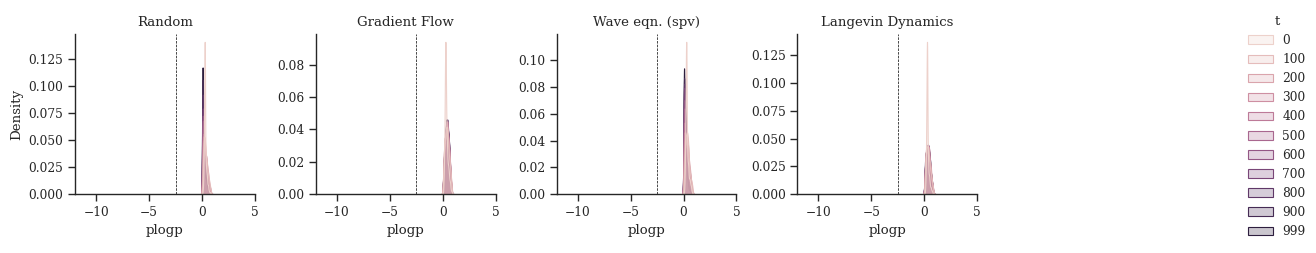

In [16]:
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='serif',
)

# fig, ax = plt.subplots()

sup_line = df_all.query('t == 999 and name == "Langevin Dynamics"')[prop].mean()

_df = df_all.query(
    '(t % 100 == 0 or t == 999) and name in ["Random", "ChemSpace", "Gradient Flow", "Wave eqn. (spv)", "Langevin Dynamics"]')
# _df = df_all.query('t % 100 == 0 or t == 999')

# set x-axis limits -10 to 10
g = sns.displot(_df, x=prop, hue='t', kind='kde', fill=True, col='name', height=2.5,
                col_wrap=5, facet_kws={'sharey': False})
g.set_titles('{col_name}')
g.set_xlabels('plogp')
for ax in g.axes.flat:
    ax.set_xlim(-12, 5)
    #plot vertical line at x=0
    ax.axvline(-2.5, color='black', linestyle='--', lw=0.5)
#create the directories if they don't exist
if not (Path('figures/optimization') / prop).exists():
    (Path('figures/optimization') / prop).mkdir(parents=True, exist_ok=True)
# save the figure
g.savefig(f'figures/optimization/{prop}_spv_kde.pdf')
g.savefig(f'figures/optimization/{prop}_spv_kde.png')

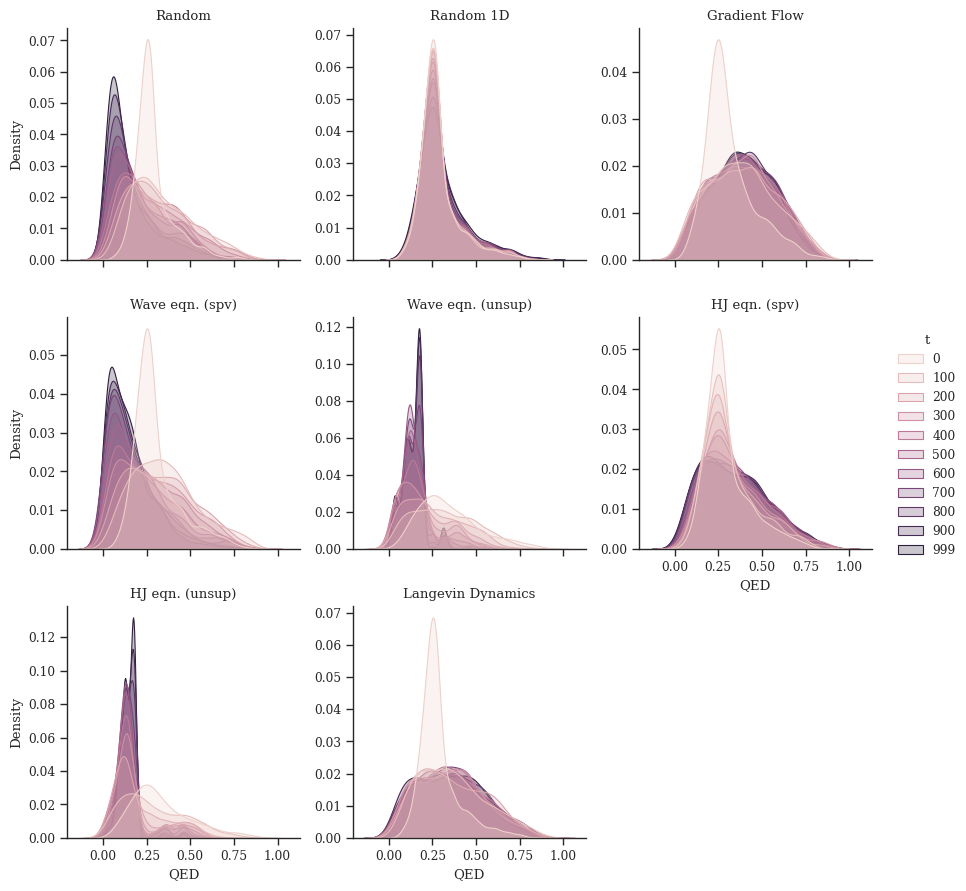

In [17]:
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='serif',
)
# sns.set_theme()

_df = df_all.query('t % 100 == 0 or t == 999')
# _df = df_all.query('t % 100 == 0 or t == 999')

g = plt = sns.displot(_df, x=prop, hue='t', kind='kde', fill=True, col='name',
                      col_wrap=3, height=3, facet_kws={'sharey': False})
g.set_titles('{col_name}')
g.set_xlabels('QED')
# for ax in g.axes.flat:
#     ax.set_xlim(-12, 5)
#     #plot vertical line at x=0
#     ax.axvline(-2.5, color='black', linestyle='--', lw=0.5)
g.savefig(f'figures/optimization/{prop}_kde.pdf')
g.savefig(f'figures/optimization/{prop}_kde.png')

In [18]:
df_all.query('name == "ChemSpace" and t == 999').smiles.value_counts()

Series([], Name: count, dtype: int64)

In [19]:
df_all.query('name == "Langevin Dynamics" and t == 999').smiles.value_counts()

smiles
O1C=CC=CCCCNC(=O)OC=CC2=CN=CC(=C2C[NH1]3)C=CN=C1C3=CS       1
O=C1C#C1                                                    1
CCN1CC=C(S)S(C(=S)OCl)[NH1]CCONO1                           1
CCC(CCOC=O)C1NC[NH1][NH1]CC1                                1
CCON=CNSCC=CC=1C(Cl)C=CC=1C                                 1
                                                           ..
N1C(POC=C2N=C3CF)C(=O)S3CC21OC                              1
C1NC(CSCCNC(=O)C(Br)C=NC(C=CC=C(F)COC)(Cl)C=NCS1=O)N=CCN    1
C1OC=CNCC(C)NC=C(COC(C=CN=CN(O)CCl)F)NOCC=CC=C1             1
CCN1N2NNS1COCCNCCC=C(OCN2O3)OC(C)CC=CC=C3F                  1
C1C(CCCN1C2COC[C@H1]C2SO3)ONC(=O)OC=C[NH1]O3                1
Name: count, Length: 800, dtype: int64

In [20]:
df_all.query('name == "LIMO" and t == 999').smiles.value_counts()

Series([], Name: count, dtype: int64)

In [21]:
df_all.query('name == "Random" and t == 999').smiles.value_counts()

smiles
O=CNC=O                                            3
N1NC=C1NC(N)CNCOC=C2N=CS(C=C=CC(F)(C)C2)Cl         2
O=CNC[NH1]C=C                                      2
O=CN=COC(N)NN(C)NC=CN=CSS=CCC=CC=NCF               2
C=CC=CC(C(=N)C(NCSOC=CN)=CSS=CC1C=CC2=NC1C)=CO2    1
                                                  ..
NNCCNC(N)NNNOC=CS(S=CC=O)=CCCl                     1
N1NC=C1NC(N)N2NCOC=C3C(CC=CC3C=CO2)Cl              1
C12=CC=C1NC2=N                                     1
O=CC=C[NH1]C(=O)NN(C)COC(=CNS=CC=O)O               1
O=CC=COC(=C)N(NCNOC(=C)N)CCC=CC=O                  1
Name: count, Length: 795, dtype: int64

In [22]:
df_all.query('name == "Wave eqn. (unsup)" and t == 999').smiles.value_counts()

smiles
NC=C=C=CC=CNSSC=O                                    243
O=CC=CNOONCC=CN                                       51
NC=C=C=CC=CNSSC=CC(C)C(Br)C=NN=NS1=C=C(OC=O)C1Cl      49
O=CC=CNOC=CN                                          46
O=CC=CNOONOC=CN                                       43
                                                    ... 
O=CC=CNONNOC=CN                                        1
O=CC=CNC=CNOCNN                                        1
NC=C=C=CC=CNSSC=CC(=O)C(Br)C=NN=NS1=C=C(OC=O)C1Cl      1
O=CC=CNOC=CNC=CNC(NCO)COCC=CC=CCOC=C                   1
O=CC=CNOONCC=CNCC=O                                    1
Name: count, Length: 79, dtype: int64

In [23]:
sns.color_palette("rocket")

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [24]:
deltas = torch.zeros((n, steps))
results = []

for file, name in tqdm(sim_files):
    df = pd.read_csv(file, index_col=0)

    for sim in [0, 0.2, 0.4, 0.6]:
        df = df.query(f'sim >= {sim}')
        deltas.zero_()
        for _, row in df.iterrows():
            deltas[row['idx'], row['t']] = row['delta']
        improvements = torch.cummax(deltas, dim=1).values.mean(dim=0)  # (steps,)

        _df = pd.DataFrame({
            't': range(steps),
            'improvement': improvements.cpu().numpy(),
            'name': name,
            'sim': sim
        })
        results.append(_df)

df_results = pd.concat(results)

show_df(df_results)

  0%|          | 0/8 [00:00<?, ?it/s]

,t,improvement,name,sim
0,0,0.000000,Random,0.0
1,1,0.000262,Random,0.0
2,2,0.001617,Random,0.0
3,3,0.002393,Random,0.0
4,4,0.002807,Random,0.0


(32000, 4)


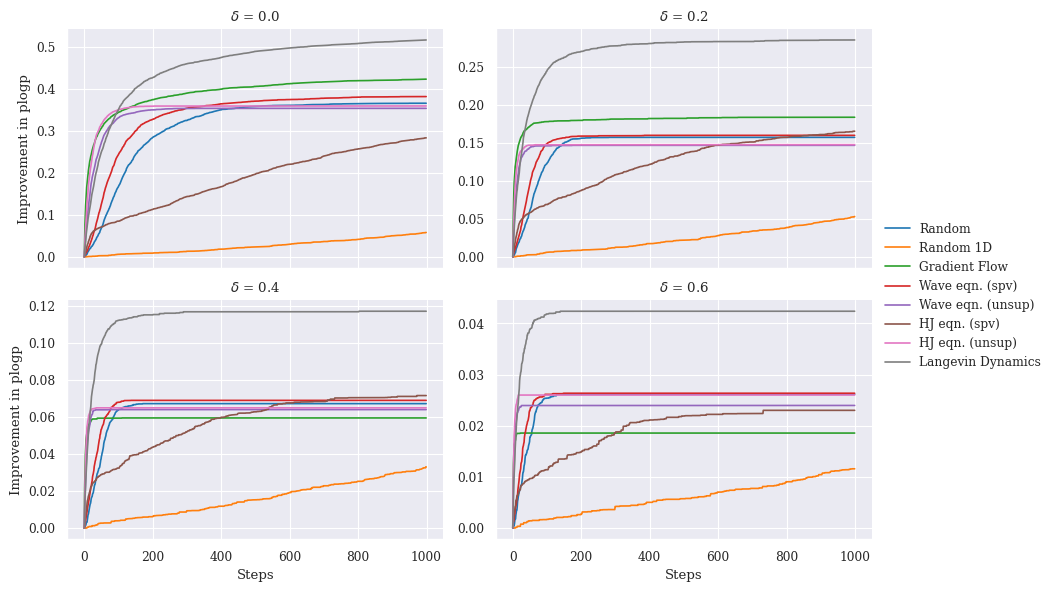

In [25]:
sns.set_theme(
    context='paper',
    style='darkgrid',
    palette='tab10',
    font='serif',
)

_df = df_results
# _df = df_conv.query('(t % 100 == 0 or t == 999) and name in ["Random", "Langevin Dynamics"]')

# sns.set_theme(context='paper', style='white')
# sns.set_theme()

g = sns.relplot(
    data=_df, x='t', y='improvement', hue='name', col='sim',
    kind='line', height=3, errorbar=None, col_wrap=2,
    facet_kws={'sharey': False}, aspect=1.5,
)
# remove legend title
g.legend.set_title('')
g.set_titles('$\delta$ = {col_name}')
g.set_xlabels('Steps')
g.set_ylabels('Improvement in plogp')
g.savefig(f'figures/optimization/{prop}_conv.pdf')
g.savefig(f'figures/optimization/{prop}_conv.png')